In [9]:
from glob import glob
import os

os.environ["CUDA_VISIBLE_DEVICES"] = '2'

In [2]:
DRUM_CLASSES = [
   'Kick',
   'Snare',
   'Hi-hat closed',
   'Hi-hat open',
   'Tom low',
   'Tom mid', 
   'Tom high',
   'Clap',
   'Rim' 
]
MIDI_DRUM_MAP = {
   36: 0,
   35: 0,
   38: 1,
   27: 1,
   28: 1,
   31: 1,
   32: 1,
   33: 1,
   34: 1,
   37: 1,
   39: 1,
   40: 1,
   56: 1,
   65: 1,
   66: 1,
   75: 1,
   85: 1,
   42: 2,
   44: 2,
   54: 2,
   68: 2,
   69: 2,
   70: 2,
   71: 2,
   73: 2,
   78: 2,
   80: 2,
   46: 3,
   67: 3,
   72: 3,
   74: 3,
   79: 3,
   81: 3,
   45: 4,
   29: 4,
   41: 4,
   61: 4,
   64: 4,
   84: 4,
   48: 5,
   47: 5,
   60: 5,
   63: 5,
   77: 5,
   86: 5,
   87: 5,
   50: 6,
   30: 6,
   43: 6,
   62: 6,
   76: 6,
   83: 6,
   49: 7,
   55: 7,
   57: 7,
   58: 7,
   51: 8,
   52: 8,
   53: 8,
   59: 8,
   82: 8
}

resolution  = 4 # separate quater into 4  = 16 notes per bar

nb_bars = 2 

len_seq = resolution * 4 * nb_bars # length of drumloops in training data - 2 bars
    
nb_notes = len(DRUM_CLASSES) # number of possible MIDI notes  - max_drum_note - min_drum_note


In [4]:
import random
import numpy as np
import os
import joblib
import pretty_midi
import glob

import matplotlib.pyplot as plt
%matplotlib inline

MIN_NB_ONSETS = 8

drum_dists = {}

def plot_drum_matrix(a):
    if a is not None:
        a = np.transpose(np.squeeze(a))
        plt.matshow(a)
        plt.show()  

# # unit timestep = 16th note
# def get_pianomatrices_of_drums(midi_file, is_drum=True):
#     found = False
#     genre_id = -1
    
#     # is it in selected genres?
#     for id_, genre in enumerate(GENRES):
#         if genre in midi_file:
#             found = True
#             genre_id = id_
#             break
#     if found is False:
#         return None
    
#     # load midi file
#     try:
#         pm = pretty_midi.PrettyMIDI(midi_file)
#     except:
#         print ("Failed to load midi: ", midi_file)
#         return None
        
#     # get timiming of quater notes
#     beats = pm.get_beats()
    
#     # make it to 16th notes
#     beats_ticks = [] # converting to ticks
    
#     for i in range((len(beats) +1)* 4):
#         beats_ticks.append(i * pm.resolution / 4)
    
#     num_notes16 = len(beats_ticks)
#     print(num_notes16, midi_file)
    
#     # maximum duration of one note
#     max_duration = 2.0 # 2 quater notes

#     # convert ticks to index of 16th note
#     def find_note_index(tick, beats_ticks):
#         return (np.abs(beats_ticks - tick)).argmin()
    
#     def get_timeshift(beats_ticks, grid_id, note_start):
#         grid_start = beats_ticks[grid_id]
#         tick_diff = note_start - grid_start
#         tick_grid = pm.resolution / 4        
#         diff_coef= tick_diff / tick_grid * 2.0
#         return diff_coef
        
#     # # of notes
#     notes_length = 4 * nb_bars * resolution

#     # create pianoroll matrix (resolution: 16th note))
#     found_extra = False # with other than kick/snare/hat
#     pianorolls, timeshifts, durations, genre_ids = [], [], [], []
#     for instrument in pm.instruments:
#         if instrument.is_drum == is_drum or 1:  # use drum tracks only
            
#             for note_start in range(0, num_notes16 - 16, 16): # hopsize = 1bar = 16 16th notes
#                 if note_start + notes_length > num_notes16:
#                     continue
#                 pianoroll = np.zeros((notes_length, nb_notes), dtype='float') 
#                 timeshift = np.zeros((notes_length, nb_notes), dtype='float')
#                 duration = np.zeros((notes_length, nb_notes), dtype='float')

#                 for note in instrument.notes:
#                     idx_start = find_note_index(pm.time_to_tick(note.start), beats_ticks)
#                     diff_coef = get_timeshift(beats_ticks, idx_start, pm.time_to_tick(note.start))

#                     if note_start <= idx_start and idx_start < note_start + notes_length:
#                         if note.pitch in MIDI_DRUM_MAP:
#                             drum_note = MIDI_DRUM_MAP[note.pitch]
                            
#                             if drum_note in drum_dists:
#                                 drum_dists[drum_note] += 1
#                             else:
#                                 drum_dists[drum_note] = 1
                            
#                             pianoroll[idx_start - note_start, drum_note] = note.velocity / 128.
#                             timeshift[idx_start - note_start, drum_note] = diff_coef

#                             dur = (pm.time_to_tick(note.end) - pm.time_to_tick(note.start))/ (pm.resolution / 4)
#                             dur = min(1.0, max(0, dur / max_duration))
#                             duration[idx_start - note_start, drum_note] = dur

#                             if drum_note >= 3:
#                                 found_extra = True
#                         else:
#                             print("not found", note.pitch )
                
#                 if np.sum(pianoroll > 0.) >= MIN_NB_ONSETS:
#                     pianorolls.append(pianoroll)
#                     timeshifts.append(timeshift)
#                     durations.append(duration)
#                     genre_ids.append(genre_id)
             
#     # ignore the first and the last one!
#     pianorolls = np.array(pianorolls)
#     timeshifts = np.array(timeshifts)
#     durations = np.array(durations)
#     genre_ids = np.array(genre_ids)
    
#     return (pianorolls,timeshifts, durations, genre_ids)
    
# midi_file = random.choice(filepaths)
# drums, timeshift, duration, genre_ids = get_pianomatrices_of_drums(midi_file)    

# print (timeshift.shape)
# print (genre_ids.shape)
# print (timeshift.shape)

# for i in range(3):
#     plot_drum_matrix(drums[i])


In [5]:
import numpy as np

matrices_drums = np.load("./tmp/matrices_drum_gm_electronic.npz")['drum_data']
matrices_genres = np.load("./tmp/matrices_drum_gm_electronic.npz")['genre_ids']
GENRES_ALL = np.load("./tmp/matrices_drum_gm_electronic.npz")['genres']

print(GENRES_ALL)
print(matrices_genres.shape)

# Filter genres 
GENRES_USED = [u'Old Skool', u'DnB', u'Jungle', u'House', u'Breakbeat', u'Garage', u'Techno']
GENRES_ID_USED = [i for i, genre in enumerate(GENRES_ALL) if genre in GENRES_USED]
GENRES = [genre for i, genre in enumerate(GENRES_ALL) if genre in GENRES_USED]

print(GENRES_ID_USED)
print(GENRES)

NB_GENRES = len(GENRES)
print("%d genres we have" % NB_GENRES)

_drums = []
_genres = []

for genre_id, drum in zip(matrices_genres, matrices_drums):
    if genre_id in GENRES_ID_USED:
        _drums.append(drum)
        genre_id = GENRES_ID_USED.index(genre_id)
        _genres.append(genre_id)

matrices_drums = np.array(_drums)
print(matrices_drums.shape)
matrices_genres = np.array(_genres)
print(matrices_genres.shape)

[u'Old Skool' u'Trance' u'DnB' u'Basic' u'Downtempo' u'Jungle' u'House'
 u'Breakbeat' u'Garage' u'Techno']
(49003,)
[0, 2, 5, 6, 7, 8, 9]
[u'Old Skool', u'DnB', u'Jungle', u'House', u'Breakbeat', u'Garage', u'Techno']
7 genres we have
(37950, 32, 9)
(37950,)


(u'Old Skool', 3595)


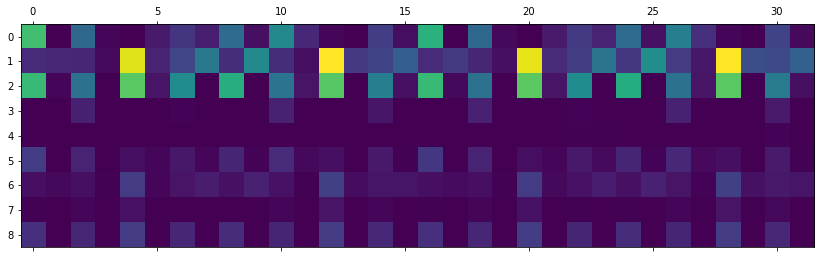

(u'DnB', 6931)


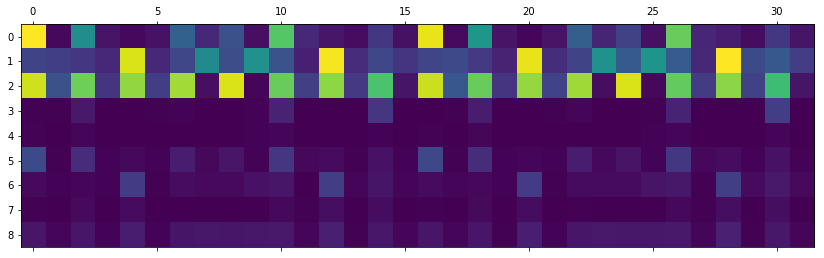

(u'Jungle', 4795)


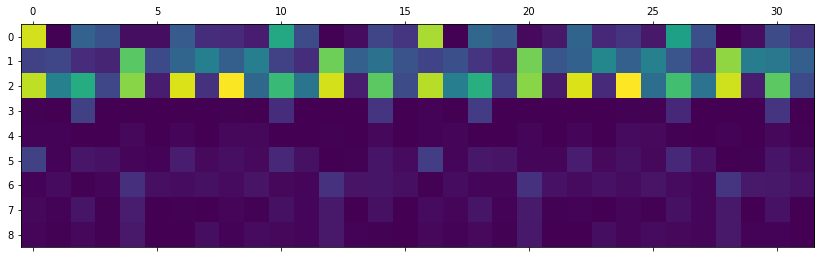

(u'House', 3595)


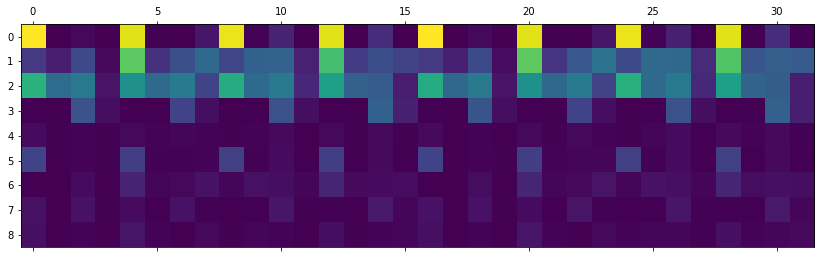

(u'Breakbeat', 8403)


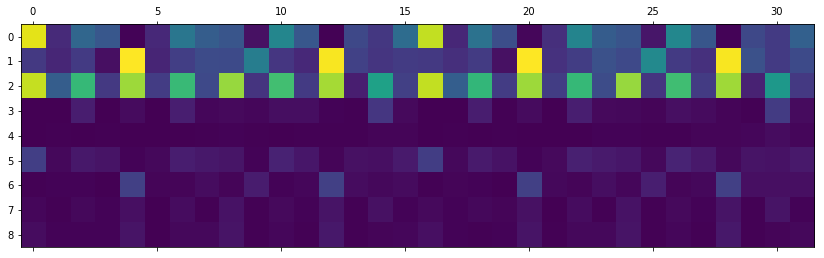

(u'Garage', 6618)


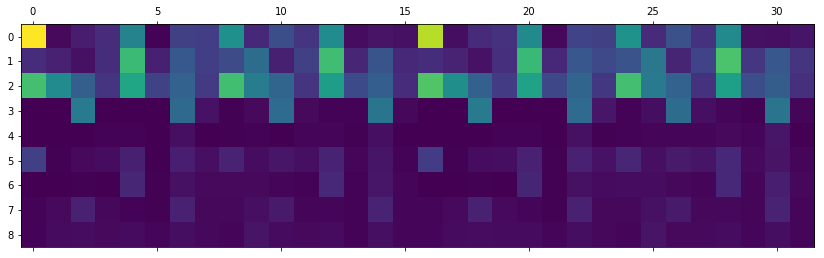

(u'Techno', 4013)


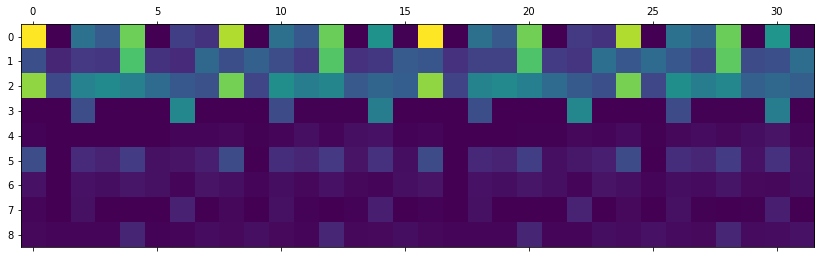

In [6]:
for i, genre in enumerate(GENRES):
    a = matrices_drums[matrices_genres == i]
    print(genre, int(a.shape[0]))
    
    b = np.mean(a, axis=0)
    s = np.std(a, axis=0)
#    print(s.shape)
    plot_drum_matrix(b)
#    plot_drum_matrix(s)

In [7]:
import numpy as np
from keras.layers import Input, Dense, Flatten, Dropout, Reshape, LSTM, Bidirectional, Lambda, Concatenate, Softmax
from keras.layers.convolutional import Conv2D

from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import RMSprop, Adam
import keras.backend as K
from keras.models import Model, Sequential

batch_size = 16
n_z = 4
dropout_rate = 0.30

# encoder
drum_input = Input(shape=(len_seq, nb_notes), name='drum_input')  # tensorflow order
x = Bidirectional(LSTM(64, return_sequences=True, activation='tanh'))(drum_input) 
x = Bidirectional(LSTM(128, return_sequences=True, activation='tanh'))(x)
x = Bidirectional(LSTM(16, return_sequences=True, activation='tanh'))(x)
x1 = Reshape((1024,))(x)
x = Dense(512, activation='relu')(x1)
x = Dense(256, activation='relu')(x)
x = Dense(NB_GENRES, activation='relu')(x)
output = Softmax()(x)

model = Model(drum_input, output)
model.summary()


Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
drum_input (InputLayer)      (None, 32, 9)             0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32, 128)           37888     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 32, 256)           263168    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 32, 32)            34944     
_________________________________________________________________
reshape_1 (Reshape)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
__________

In [8]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical 

genre_ids = to_categorical(matrices_genres, num_classes=NB_GENRES)

es = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
cp = ModelCheckpoint("./tmp/rythm_classification_gm_{epoch:02d}-{val_loss:.2f}.hdf5", monitor='val_loss', verbose=1, save_best_only=True, period=3)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

BATCH_SIZE = 64

model.fit(matrices_drums, genre_ids, 
        shuffle=True, batch_size=BATCH_SIZE, epochs=100, verbose=1, validation_split=0.1, callbacks=[es, cp])

Train on 34155 samples, validate on 3795 samples
Epoch 1/100
34155/34155 [==============================] - 141s 4ms/step - loss: 1.0137 - acc: 0.6217 - val_loss: 0.4106 - val_acc: 0.8224
Epoch 2/100
34155/34155 [==============================] - 135s 4ms/step - loss: 0.2972 - acc: 0.8780 - val_loss: 0.3556 - val_acc: 0.8316
Epoch 3/100
34155/34155 [==============================] - 134s 4ms/step - loss: 0.2269 - acc: 0.8986 - val_loss: 0.3020 - val_acc: 0.8469

Epoch 00003: val_loss improved from inf to 0.30201, saving model to ./tmp/rythm_classification_gm_03-0.30.hdf5
Epoch 4/100
34155/34155 [==============================] - 136s 4ms/step - loss: 0.2100 - acc: 0.9035 - val_loss: 0.2994 - val_acc: 0.8480
Epoch 5/100
34155/34155 [==============================] - 136s 4ms/step - loss: 0.2008 - acc: 0.9054 - val_loss: 0.2999 - val_acc: 0.8472
Epoch 6/100
34155/34155 [==============================] - 136s 4ms/step - loss: 0.2015 - acc: 0.9061 - val_loss: 0.3022 - val_acc: 0.8458

Epoc